<a href="https://colab.research.google.com/github/bahador1/I-GOS/blob/main/I_GOS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#coding=utf-8
# Generating video using I-GOS
# python Version: python3.6
# by Zhongang Qi (qiz@oregonstate.edu)
# from util import *
import os
import time
import scipy.io as scio
import datetime
import re
import matplotlib.pyplot as plt
import numpy as np
import pylab
import os
import csv
from skimage import transform, filters
from textwrap import wrap
import cv2
#coding=utf-8
# util.py
# python Version: python3.6
# by Zhongang Qi (qiz@oregonstate.edu)
import torch
from torch.autograd import Variable
from torchvision import models
import cv2
import sys
import numpy as np
import matplotlib as mpl
#mpl.use('Agg')
import matplotlib.pyplot as plt
from skimage import filters

from typing import Tuple
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
Tensor = FloatTensor

## progression of img
- `Get_blurred_img`:
    1.   `cv2.imread(input_img, 1)`, `1` → Loads a color image in BGR format (default)
    2.   `cv2.resize(original_img, resize_shape)`
    3.   `np.float32(original_img)`
    4.   `.../ 255`
    5. `preprocess_image(img,...)`
        1. -
        2. BGR → RGB(common when reading images with OpenCV).
        3. normalization with standard ImageNet normalization values.
        4. Converts from shape `(H, W, C)` to `(C, H, W)`/ which PyTorch expects.
        5. torch.from_numpy (`.cuda()`, `.cpu()`)
        6. `unsqueeze(0)`  (1, C, H, W).
    6. **output**:
        - `original_image`: resized numpy image / BGR
        - `img`: - BGR - , np.float32()/ 255
        - `blurred_img`: -BGR - np.float32()/255
        - `logitori`

### utils

In [ ]:

def topmaxPixel(HattMap: np.ndarray, thre_num: int) -> Tuple[np.ndarray, float]:
    '''
    parameters:
    -----
    HattMap: it is a deletion mask/heatmap
    thre_num:



    output:
    ------
    OutHattMap:
    img_ratio :
    '''

    ###bm1###
    # print("the Hattmap is ", HattMap)
    # filename = 'my_data.pkl'
    # 3. Open the file in 'wb' mode and dump the object into it.
    # with open(filename, 'wb') as file:
        # pickle.dump(HattMap, file)

    # print(f"Object has been saved to {filename}")
    flatten = HattMap.ravel()
    idx_sort_ascending = np.argsort(flatten)
    first_smallest_threnumth =idx_sort_ascending[: thre_num] #first thre
    ii = np.unravel_index(first_smallest_threnumth, HattMap.shape)

    print("HattMap.shape", HattMap.shape)
    print("-------------------ii---------------------")
    print(ii)
    print("------------------------------------------")

    OutHattMap = HattMap*0
    OutHattMap[ii] = 1

    img_ratio = np.sum(OutHattMap) / OutHattMap.size
    OutHattMap = 1 - OutHattMap
    #######bm1###
    filename = 'OutHattMap.pkl'
    # 3. Open the file in 'wb' mode and dump the object into it.
    with open(filename, 'wb') as file:
        pickle.dump(OutHattMap, file)

    # print(f"Object has been saved to {filename}")
    #####################
    return OutHattMap, img_ratio


def topmaxPixel_insertion(HattMap, thre_num):
    ii = np.unravel_index(np.argsort(HattMap.ravel())[: thre_num], HattMap.shape)
    # print(ii)
    OutHattMap = HattMap * 0
    OutHattMap[ii] = 1

    img_ratio = np.sum(OutHattMap) / OutHattMap.size

    return OutHattMap, img_ratio


In [ ]:


def tv_norm(input, tv_beta):
    img = input[0, 0, :]
    row_grad = torch.mean(torch.abs((img[:-1, :] - img[1:, :])).pow(tv_beta))
    col_grad = torch.mean(torch.abs((img[:, :-1] - img[:, 1:])).pow(tv_beta))
    return row_grad + col_grad


def preprocess_image(
        img: np.ndarray,
        use_cuda: bool = True,
        require_grad: bool = False) -> torch.Tensor:
    """

    what does this function do?
    These means and stds are the standard ImageNet normalization values.
    Most pretrained PyTorch models (like ResNet, VGG) expect input images
    normalize with these.

    This reverses the channel order. If your input is in RGB,
    it becomes BGR (common when reading images with OpenCV).

    output:
    1. `preprocessed_img_tensor`: normalized
    """
    means = [0.485, 0.456, 0.406]
    stds = [0.229, 0.224, 0.225]


    preprocessed_img = img.copy()[:, :, ::-1]# (224,224,BGR) -> (224, 224, RGB)

    for i in range(3):
        # But notice: this assumes img has pixel values already scaled to [0,1],
        # otherwise the normalization won’t work as intended.
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] - means[i]
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] / stds[i]
    preprocessed_img = \
        np.ascontiguousarray(np.transpose(preprocessed_img, (2, 0, 1)))
        #Ensures the array is contiguous in memory for efficient tensor conversion.

    if use_cuda:
        preprocessed_img_tensor = torch.from_numpy(preprocessed_img).cuda()
    else:
        preprocessed_img_tensor = torch.from_numpy(preprocessed_img)

    preprocessed_img_tensor.unsqueeze_(0)
    return Variable(preprocessed_img_tensor, requires_grad=require_grad)


def numpy_to_torch(img, use_cuda=1, requires_grad=False):
    if len(img.shape) < 3:
        output = np.float32([img])
    else:
        output = np.transpose(img, (2, 0, 1))

    output = torch.from_numpy(output)
    if use_cuda:
        output = output.cuda()

    output.unsqueeze_(0)
    v = Variable(output, requires_grad=requires_grad)
    return v


def load_model_new(use_cuda = 1, model_name = 'resnet50'):

    if model_name == 'resnet50':
        model = models.resnet50(pretrained=True)
    elif model_name == 'vgg19':
        model = models.vgg19(pretrained=True)

    #print(model)
    model.eval()
    if use_cuda:
        model.cuda()

    for p in model.parameters():
        p.requires_grad = False

    return model


def save_heatmap(output_path, upsampled_mask, img, blurred, blur_mask=0):
    """
    input:
    save_heatmap(output_file, upsampled_mask, img * 255, blurred_img, blur_mask=0)
    """

    mask  = upsampled_mask
    mask = mask.cpu().data.numpy()[0]
    mask = np.transpose(mask, (1, 2, 0))
    mask = (mask - np.min(mask)) / (np.max(mask)-np.min(mask))
    mask = 1 - mask

    # if blur_mask:
    #     mask = cv2.GaussianBlur(mask, (11, 11), 10)
    #     mask = np.expand_dims(mask, axis=2)

    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255


    img = np.float32(img) / 255
    perturbated = np.multiply(1 - mask, img) + np.multiply(mask, blurred)

    IGOS = 1 * (1 - mask ** 0.8) * img + (mask ** 0.8)* heatmap;



    cv2.imwrite(output_path + "heatmap.png", np.uint8(255 * heatmap))
    cv2.imwrite(output_path + "IGOS.png", np.uint8(255 * IGOS))
    cv2.imwrite(output_path + "blurred.png", np.uint8(255 * blurred))

In [ ]:

def save_new(mask, img, blurred):
    ########################
    # generate the perturbed image
    #
    # parameters:
    # mask: the generated mask its the deletion mask
    # img: the original image
    # blurred: the baseline image



    #output
    # ed, ed ,ed masked image
    ####################################################
    mask = mask.cpu().data.numpy()[0]
    mask = np.transpose(mask, (1, 2, 0)) # from channels-firs torch tensor to numpy/TF/keras channel last tensor
    img = np.float32(img) / 255
    perturbated = np.multiply(mask, img) + np.multiply(1-mask, blurred)
    perturbated = cv2.cvtColor(perturbated, cv2.COLOR_BGR2RGB)
    return perturbated

### main functions

In [ ]:
def Get_blurred_img(input_img, img_label, model, resize_shape=(224, 224), Gaussian_param = [51, 50], Median_param = 11, blur_type= 'Gaussian', use_cuda = 1):
    ########################
    # Generate blurred images as the baseline

    # Parameters:
    # -------------
    # input_img: the original input image
    # img_label: the classification target that you want to visualize (img_label=-1 means the top 1 classification label)
    # model: the model that you want to visualize
    # resize_shape: the input size for the given model
    # Gaussian_param: parameters for Gaussian blur
    # Median_param: parameters for median blur
    # blur_type: Gaussian blur or median blur or mixed blur
    # use_cuda: use gpu (1) or not (0)

    #output
    # ----
    # original_img: resized numpy image
    # img:  - BGR -,   np.float32()/255
    # blurred_img -BGR - np.float32()/255
    # logitori: class score
    ####################################################

    original_img = cv2.imread(input_img, 1)#1 → Loads a color image in BGR format (default)
    original_img = cv2.resize(original_img, resize_shape)
    img = np.float32(original_img) / 255

    if blur_type =='Gaussian':   # Gaussian blur
        Kernelsize = Gaussian_param[0]
        SigmaX = Gaussian_param[1]
        blurred_img = cv2.GaussianBlur(img, (Kernelsize, Kernelsize), SigmaX)

    elif blur_type == 'Median': # Median blur
        Kernelsize_M = Median_param
        blurred_img = np.float32(cv2.medianBlur(original_img, Kernelsize_M)) / 255

    elif blur_type == 'Mixed': # Mixed blur
        Kernelsize = Gaussian_param[0]
        SigmaX = Gaussian_param[1]
        blurred_img1 = cv2.GaussianBlur(img, (Kernelsize, Kernelsize), SigmaX)

        Kernelsize_M = Median_param
        blurred_img2 = np.float32(cv2.medianBlur(original_img, Kernelsize_M)) / 255

        blurred_img = (blurred_img1 + blurred_img2) / 2



    img_torch = preprocess_image(img, use_cuda, require_grad = False)
    # blurred_img_torch = preprocess_image(blurred_img, use_cuda, require_grad = False)

    ori_output = model(img_torch)
    # blurred_output = model(blurred_img_torch)

    # compute the outputs for the original image and the blurred image
    if use_cuda:
        logitori = ori_output.data.cpu().numpy().copy().squeeze()
        # logitblur = blurred_output.data.cpu().numpy().copy().squeeze()
    else:
        logitori = ori_output.data.numpy().copy().squeeze()
        # logitblur = blurred_output.data.cpu().numpy().copy().squeeze()


    # top_5_idx = np.argsort(logitori)[-5:]
    # top_5_values = [logitori[i] for i in top_5_idx]
    # print('top_5_idx:', top_5_idx, top_5_values)

    # find the original top 1 classification label
    # rew = np.where(logitori == np.max(logitori))
    #print(rew)
    # output_label = rew[0][0]

    # if img_label=-1, choose the original top 1 label as the one that you want to visualize
    # if img_label == -1:
    #     img_label = output_label

    # rew_blur = np.where(logitblur == np.max(logitblur))
    # output_label_blur = rew_blur[0][0]



    #print('ori_output:', ori_output[0, img_label], output_label)
    #print('blurred_output:', blurred_output[0, img_label], output_label_blur)
    # blur_ratio = blurred_output[0, img_label] / ori_output[0, img_label]
    #print('blur_ratio:', blur_ratio)


    return original_img, img, blurred_img, logitori



In [ ]:
def Integrated_Mask(img, blurred_img, model, category, max_iterations = 15, integ_iter = 20,
                    tv_beta=2, l1_coeff = 0.01*300, tv_coeff = 0.2*300, size_init = 112, use_cuda =0):
    ########################
    # IGOS: using integrated gradient descent to find the smallest and smoothest area that maximally decrease the output of a deep model

    # Parameters:
    # -------------
    # img: the original input image
    # blurred_img: the baseline for the input image
    # model: the model that you want to visualize
    # category: the classification target that you want to visualize (category=-1 means the top 1 classification label)
    # max_iterations: the max iterations for the integrated gradient descent
    # integ_iter: how many points you want to use when computing the integrated gradients
    # tv_beta: which norm you want to use for the total variation term
    # l1_coeff: parameter for the L1 norm
    # tv_coeff: parameter for the total variation term
    # size_init: the resolution of the mask that you want to generate
    # use_cuda: use gpu (1) or not (0)


    # return:
    # --------------
    # mask, upsampled_mask, imgratio, curvetop, curve1, curve2, category
    ####################################################
    img_ori= img.copy() # me
    blurred_img_ori = blurred_img.copy()#me

    # preprocess the input image and the baseline image
    img_torch         = preprocess_image(img,         use_cuda, require_grad=False)###
    blurred_img = preprocess_image(blurred_img, use_cuda, require_grad=False)

    resize_size = img_torch.data.shape###
    resize_wh = (img_torch.data.shape[2], img_torch.data.shape[3])###

    # if use_cuda:
    #     zero_img = Variable(torch.zeros(resize_size).cuda(), requires_grad=False)
    # else:
    #     zero_img = Variable(torch.zeros(resize_size), requires_grad=False)

    # initialize the mask
    mask_init = np.ones((size_init, size_init), dtype=np.float32)
    mask      = numpy_to_torch(mask_init, use_cuda, requires_grad=True)

    if use_cuda:
        upsample = torch.nn.UpsamplingBilinear2d(size=resize_wh).cuda()
    else:
        upsample = torch.nn.UpsamplingBilinear2d(size=resize_wh)

    # You can choose any optimizer
    # The optimizer doesn't matter, because we don't need optimizer.step(), we just use it to compute the gradient
    optimizer = torch.optim.Adam([mask], lr=0.1)
    #optimizer = torch.optim.SGD([mask], lr=0.1)

    target = torch.nn.Softmax(dim=1)(model(img_torch))###
    if use_cuda:
        category_out = np.argmax(target.cpu().data.numpy())
    else:
        category_out = np.argmax(target.data.numpy())

    # if category=-1, choose the original top 1 category as the one that you want to visualize
    if category ==-1:
        category = category_out

    # print("Category with highest probability", category_out)
    # print("Category want to generate mask", category)
    print("Optimizing.. ")




    curve1 = np.array([])
    curve2 = np.array([])
    curvetop = np.array([])


    # Integrated gradient descent
    alpha = 0.0001
    beta = 0.2

    #IGOS optimization using IG
    for i in range(max_iterations):
        upsampled_mask = upsample(mask)
        # The single channel mask is used with an RGB image,
        # so the mask is duplicated to have 3 channels
        upsampled_mask = \
            upsampled_mask.expand(1, 3, upsampled_mask.size(2), \
                                  upsampled_mask.size(3))


        # the l1 term and the total variation term
        loss1 = l1_coeff * torch.mean(torch.abs(1 - mask)) + \
                tv_coeff * tv_norm(mask, tv_beta)
        loss_all = loss1.clone()

        # compute the perturbed image
        perturbated_input_base = img_torch.mul(upsampled_mask) + \
                                 blurred_img.mul(1 - upsampled_mask)


        #IG
        for inte_i in range(integ_iter):


            # Use the mask to perturbated the input image.
            integ_mask = 0.0 + ((inte_i + 1.0) / integ_iter) * upsampled_mask


            perturbated_input_integ = img_torch.mul(integ_mask) + \
                                     blurred_img.mul(1 - integ_mask)

            # add noise
            noise = np.zeros((resize_wh[0], resize_wh[1], 3), dtype=np.float32)
            noise = noise + cv2.randn(noise, 0, 0.2)
            noise = numpy_to_torch(noise, use_cuda, requires_grad=False)

            perturbated_input = perturbated_input_integ + noise

            new_image = perturbated_input
            outputs = torch.nn.Softmax(dim=1)(model(new_image))
            loss2 = outputs[0, category]

            loss_all = loss_all + loss2/20.0


        # compute the integrated gradients for the given target,
        # and compute the gradient for the l1 term and the total variation term
        optimizer.zero_grad()
        loss_all.backward()
        whole_grad = mask.grad.data.clone()

        loss2_ori = torch.nn.Softmax(dim=1)(model(perturbated_input_base))[0, category]

        loss_ori = loss1 + loss2_ori
        if i==0:
            if use_cuda:
                curve1 = np.append(curve1, loss1.data.cpu().numpy())
                curve2 = np.append(curve2, loss2_ori.data.cpu().numpy())
                curvetop = np.append(curvetop, loss2_ori.data.cpu().numpy())

            else:
                curve1 = np.append(curve1, loss1.data.numpy())
                curve2 = np.append(curve2, loss2_ori.data.numpy())
                curvetop = np.append(curvetop, loss2_ori.data.numpy())



        if use_cuda:
            loss_oridata = loss_ori.data.cpu().numpy()
        else:
            loss_oridata = loss_ori.data.numpy()



        # LINE SEARCH with revised Armijo condition
        step = 200.0
        MaskClone = mask.data.clone()
        MaskClone -= step * whole_grad
        MaskClone = Variable(MaskClone, requires_grad=False)
        MaskClone.data.clamp_(0, 1) # clamp the value of mask in [0,1]


        mask_LS = upsample(MaskClone)   # Here the direction is the whole_grad
        Img_LS = img_torch.mul(mask_LS) + \
                 blurred_img.mul(1 - mask_LS)
        outputsLS = torch.nn.Softmax(dim=1)(model(Img_LS))
        loss_LS = l1_coeff * torch.mean(torch.abs(1 - MaskClone)) + \
                  tv_coeff * tv_norm(MaskClone, tv_beta) + outputsLS[0, category]

        if use_cuda:
            loss_LSdata = loss_LS.data.cpu().numpy()
        else:
            loss_LSdata = loss_LS.data.numpy()


        new_condition = whole_grad ** 2  # Here the direction is the whole_grad
        new_condition = new_condition.sum()
        new_condition = alpha * step * new_condition

        while loss_LSdata > loss_oridata - new_condition.cpu().numpy():
            step *= beta

            MaskClone = mask.data.clone()
            MaskClone -= step * whole_grad
            MaskClone = Variable(MaskClone, requires_grad=False)
            MaskClone.data.clamp_(0, 1)
            mask_LS = upsample(MaskClone)
            Img_LS = img_torch.mul(mask_LS) + \
                     blurred_img.mul(1 - mask_LS)
            outputsLS = torch.nn.Softmax(dim=1)(model(Img_LS))
            loss_LS = l1_coeff * torch.mean(torch.abs(1 - MaskClone)) + \
                      tv_coeff * tv_norm(MaskClone, tv_beta) + outputsLS[0, category]

            if use_cuda:
                loss_LSdata = loss_LS.data.cpu().numpy()
            else:
                loss_LSdata = loss_LS.data.numpy()


            new_condition = whole_grad ** 2  # Here the direction is the whole_grad
            new_condition = new_condition.sum()
            new_condition = alpha * step * new_condition

            if step<0.00001:
                break

        mask.data -= step * whole_grad

        #######################################################################################################
        # what the fuck is the purpose of the following procedure

        if use_cuda:
            curve1 = np.append(curve1, loss1.data.cpu().numpy())
            curve2 = np.append(curve2, loss2_ori.data.cpu().numpy())
        else:
            curve1 = np.append(curve1, loss1.data.numpy())
            curve2 = np.append(curve2, loss2_ori.data.numpy())

        mask.data.clamp_(0, 1)
        if use_cuda:
            maskdata = mask.data.cpu().numpy()
        else:
            maskdata = mask.data.numpy()

        maskdata = np.squeeze(maskdata)
        # only keep top 40 pixels of maskdata for deletion
        maskdata, imgratio = topmaxPixel(maskdata, 40)
        maskdata = np.expand_dims(maskdata, axis=0)
        maskdata = np.expand_dims(maskdata, axis=0)

        ###############################################
        if use_cuda:
            Masktop = torch.from_numpy(maskdata).cuda()
        else:
            Masktop = torch.from_numpy(maskdata)
        # Use the mask to perturbated the input image.
        Masktop = Variable(Masktop, requires_grad=False)
        MasktopLS = upsample(Masktop)
        Img_topLS = img_torch.mul(MasktopLS) + \
                    blurred_img.mul(1 - MasktopLS)



        outputstopLS = torch.nn.Softmax(dim=1)(model(Img_topLS))
        loss_top1 = l1_coeff * torch.mean(torch.abs(1 - Masktop)) + \
                    tv_coeff * tv_norm(Masktop, tv_beta)
        loss_top2 = outputstopLS[0, category]

        if use_cuda:
            curvetop = np.append(curvetop, loss_top2.data.cpu().numpy())
        else:
            curvetop = np.append(curvetop, loss_top2.data.numpy())


        if max_iterations >3:

            if i == int(max_iterations / 2):
                if np.abs(curve2[0] - curve2[i]) <= 0.001:
                    print('Adjust Parameter l1_coeff at iteration:', int(max_iterations / 2))
                    l1_coeff = l1_coeff / 10

            elif i == int(max_iterations / 1.25):
                if np.abs(curve2[0] - curve2[i]) <= 0.01:
                    print('Adjust Parameters l1_coeff again at iteration:', int(max_iterations / 1.25))
                    l1_coeff = l1_coeff / 5


            #######################################################################################

    upsampled_mask = upsample(mask)

    if use_cuda:
        mask = mask.data.cpu().numpy().copy()
    else:
        mask = mask.data.numpy().copy()

    return mask, upsampled_mask, imgratio, curvetop, curve1, curve2, category

In [ ]:
def Deletion_Insertion(mask, model, output_path, img_ori, blurred_img_ori, logitori, category, pixelnum = 200, use_cuda =1, blur_mask=0, outputfig = 1):
    ########################
    # Compute the deletion and insertion scores
    #
    # parameters:
    # mask: the generated mask - type: np - M*(so you should look the `Integrated_Mask(...)` function)
    # model: the model that you want to visualize
    # output_path: where to save the results
    # img_ori: the original image
    # blurred_img_ori: the baseline image
    # logitori: the original output for the input image
    # category: the classification target that you want to visualize (category=-1 means the top 1 classification label)
    # pixelnum: how many points you want to compute the deletion and insertion scores
    # use_cuda: use gpu (1) or not (0)
    # blur_mask: blur the mask or not
    # outputfig: save figure or not
    ####################################################

    sizeM = mask.shape[2] * mask.shape[3]
    # sizeM:  784



    # if blur_mask:
    #     mask = (mask - np.min(mask)) / np.max(mask)
    #     mask = 1 - mask
    #     mask = cv2.GaussianBlur(mask, (51, 51), 50)
    #     mask = 1-mask


    blurred_insert = blurred_img_ori.copy()                             #todo
    blurred_insert = preprocess_image(blurred_insert, use_cuda, require_grad=False)

    img = preprocess_image(img_ori, use_cuda, require_grad=False)
    blurred_img = preprocess_image(blurred_img_ori, use_cuda, require_grad=False)
    resize_wh = (img.data.shape[2], img.data.shape[3])
    # print("(Deletion_Insertion) resize_wh", resize_wh)
    # resize_wh: 224, 224

    if use_cuda:
        upsample = torch.nn.UpsamplingBilinear2d(size=resize_wh).cuda()
    else:
        upsample = torch.nn.UpsamplingBilinear2d(size=resize_wh)

    target = torch.nn.Softmax(dim=1)(model(img))

    ####
    if use_cuda:
        category_out = np.argmax(target.cpu().data.numpy())
    else:
        category_out = np.argmax(target.data.numpy())

    ####
    if category == -1:
        category = category_out

    # print("Category with highest probability (the model decision)", category_out)
    # print("Category want to generate mask", category)

    #category out: label
    # target: softmax probablity

    outmax = target[0, category].cpu().data.numpy()
    # print("outmax: Iguess its the class score", outmax)  yes 0.9959009
    # target.shape torch.Size([1, 1000])

    # logitori = logitori[category]

    del_curve = np.array([])
    insert_curve = np.array([])



    # print("sizeM: ", sizeM)# 784
    if sizeM<pixelnum:
        #this is the confusing part
        intM = 1
        # Q: is this initialize M  = 1?
    else:
        #where were we? int(sizeM/pixelnum) = int(3.92) = 3.
        intM = int(sizeM/pixelnum)


    xtick = np.arange(0, int(sizeM/3.5), intM)
    #xtick:  [  0   3   6  ...  216 219 222]

    xnum = xtick.shape[0] #xnum = 75

    xtick = xtick.shape[0]+ 10

    # get the name(e.g. fox squirrel) of the ground truth label
    f_groundtruth = open('./GroundTruth1000.txt')
    line_i = f_groundtruth.readlines()[category]
    f_groundtruth.close()


    # the hell we are doing here ?
    ## deletion
    ## insertion
    ## create ing those 75 images for building the video
    ## now here is the question. how this code multiplied the mask with the image,


    for pix_num in range(0, int(sizeM/3.5), intM):
        #pix_num : xtick steps / probably the number of pixels that we covered using mask

        ########################################################################
        ############################### deletion ###############################
        ########################################################################

        maskdata = mask.copy()
        #The same mask that was generated by the Integrated_Mask(...
        #which has the shape of (1, 1, 28, 28)

        maskdata = np.squeeze(maskdata)

        # only keep the top pixels in the mask for deletion
        print("pix_num: ", pix_num)
        maskdatatop, imgratio = topmaxPixel(maskdata, pix_num) #maskdatatop shape : (28,28)

        maskdatatop = np.expand_dims(maskdatatop, axis=0)
        maskdatatop = np.expand_dims(maskdatatop, axis=0)
        # shape of maskdatatop (1,1,28,28)

        if use_cuda:
            maskdatatopTorch = torch.from_numpy(maskdatatop).cuda()
        else:
            # Masktop = torch.from_numpy(maskdata)
            maskdatatopTorch = torch.from_numpy(maskdatatop).float() #->([1, 1, 28, 28])

        # Use the mask to perturbated the input image.
        # Masktop = Variable(Masktop, requires_grad=False)
        # print("Masktop.shape ", Masktop.shape)# torch.Size([1, 1, 28, 28])

        MasktopLS = upsample(maskdatatopTorch)
        #  MasktopLS.shape # torch.Size([1, 1, 224, 224])

        # print("\n check this thing agai, remember the goal is 40")
        # print("MasktopLS", MasktopLS.shape) #torch.Size([1, 1, 224, 224])
        # print("blurred_img", blurred_img.shape) #torch.Size([1, 1, 224, 224])
        Img_topLS = img.mul(MasktopLS) + \
                    blurred_img.mul(1 - MasktopLS)

        outputstopLS_ori = model(Img_topLS)[0, category].data.cpu().numpy().copy()
        outputstopLS = torch.nn.Softmax(dim=1)(model(Img_topLS))
        delloss_top2 = outputstopLS[0, category].data.cpu().numpy().copy()
        del_mask = MasktopLS.clone()

        delimg_ratio = imgratio.copy()
        del_ratio = delloss_top2 / outmax
        del_curve = np.append(del_curve, delloss_top2)

        #######################################################################
        ###############################insertion###############################
        #######################################################################

        maskdata = mask.copy()# same thing as the deletion procedure

        maskdata = np.squeeze(maskdata)

        maskdata, imgratio = topmaxPixel_insertion(maskdata, pix_num)

        maskdata = np.expand_dims(maskdata, axis=0)
        maskdata = np.expand_dims(maskdata, axis=0)


        if use_cuda:
            Masktop = torch.from_numpy(maskdata).cuda()
        else:
            # Masktop = torch.from_numpy(maskdata)
            Masktop = torch.from_numpy(maskdata).float()

        # Use the mask to perturbated the input image.
        # Masktop = Variable(Masktop, requires_grad=False)
        MasktopLS = upsample(Masktop)
        Img_topLS = img.mul(MasktopLS) + \
                    blurred_insert.mul(1 - MasktopLS)

        outputstopLS_ori = model(Img_topLS)[0, category].data.cpu().numpy().copy()
        outputstopLS = torch.nn.Softmax(dim=1)(model(Img_topLS))
        insloss_top2 = outputstopLS[0, category].data.cpu().numpy().copy()
        ins_mask = MasktopLS.clone()


        insimg_ratio = imgratio.copy()
        ins_ratio = insloss_top2 / outmax
        insert_curve = np.append(insert_curve, insloss_top2)

        ###############################################end of insertion#################################################

        if outputfig == 1:
            deletion_img  = save_new(del_mask, img_ori * 255, blurred_img_ori)
            # insertion_img = save_new(ins_mask, img_ori * 255, blurred_img_ori)
            #why the hell you multiply img_ori with 255?
            # same img_ori that you passed to this function


            # showimage(deletion_img, insertion_img, del_curve, insert_curve, output_path, xtick, line_i)


    # deletion_img:  (224, 224, 3) <class 'numpy.ndarray'>
    # print("deletion_img class", type(deletion_img)) #numpy array
    # print("dtype:", deletion_img.dtype)       # float32
    # print("min:", deletion_img.min())         # smallest value
    # print("max:", deletion_img.max())         # largest value
    # print("shape:", deletion_img.shape)       # confirm it's (224, 224, 3). yes fuck u :)

    plt.imshow(deletion_img)
    plt.axis("off")
    plt.show()



    outmax = np.around(outmax, decimals=3)
    delloss_top2 = np.around(delloss_top2, decimals=3)
    del_ratio = np.around(del_ratio, decimals=3)
    delimg_ratio = np.around(delimg_ratio, decimals=3)

    insloss_top2 = np.around(insloss_top2, decimals=3)
    ins_ratio = np.around(ins_ratio, decimals=3)
    insimg_ratio = np.around(insimg_ratio, decimals=3)


    return del_mask, ins_mask, delloss_top2, insloss_top2, del_ratio, ins_ratio, outmax, category, xnum

In [ ]:

# # def write_video(inputpath, outputname, img_num, fps = 10):
#     ########################
#     # Generate videos
#     #
#     # parameters:
#     # inputpath: the path for input images
#     # outputname: the output name for the video
#     # img_num: the number of the input images
#     # fps: frames per second
#     ####################################################


#     fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
#     videoWriter = cv2.VideoWriter(outputname, fourcc, fps, (1000, 1000))
#     for i in range(img_num):

#         img_no = i+1
#         # print(inputpath+'video'+str(img_no) +'.jpg')
#         img12 = cv2.imread(inputpath+'video'+str(img_no) +'.jpg',1)
#         videoWriter.write(img12)
#     videoWriter.release()

In [ ]:
def Deletion_Image(mask, model, output_file, img, blurred_img, logitori, category=-1, pixelnum=200, use_cuda=0, blur_mask=0, outputfig=1):



#### wtf
* you should normalize before plotting If:
    * `float32`
    * $\notin$ [0,1]
        * how it became normale? what is the normalization formula
            - min max shit
            - /255


---


*   according to `save_new` function, the mask in `deletation_insertion` function must be BGR   




### `if __name__ == "main"`

use_cuda False


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Optimizing.. 
HattMap.shape (28, 28)
-------------------ii---------------------
(array([11, 11, 14, 16, 12, 15, 12, 13, 15, 13, 14, 13, 12, 12, 11, 16,  7,
       10, 13, 13, 16, 14, 16, 18, 13, 11,  8,  9, 21, 26, 23, 24, 16, 16,
       16, 16, 17, 17, 17, 17]), array([17, 18, 19, 21, 17, 11, 18,  7, 19, 20,  7, 19, 19,  7, 19, 22,  8,
        5,  6,  5, 15, 10, 11,  7, 12,  5,  5,  7, 17, 14, 11, 11,  5, 16,
       17, 20, 17,  8, 10, 15]))
------------------------------------------
pix_num:  0
HattMap.shape (28, 28)
-------------------ii---------------------
(array([], dtype=int64), array([], dtype=int64))
------------------------------------------
pix_num:  3
HattMap.shape (28, 28)
-------------------ii---------------------
(array([11, 11, 14]), array([17, 18, 19]))
------------------------------------------
pix_num:  6
HattMap.shape (28, 28)
-------------------ii---------------------
(array([11, 11, 14, 16, 12, 15]), array([17, 18, 19, 21, 17, 11]))
-------------------------------

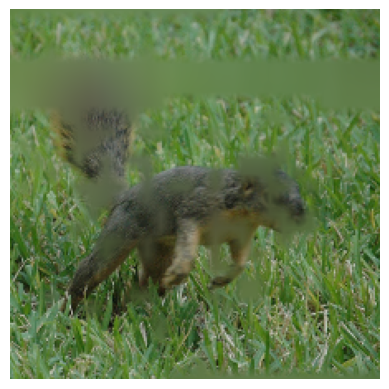

In [ ]:
input_path = './Images/'
if not os.path.exists(input_path):
    os.makedirs(input_path)

output_path = './Results/VIDEO/'
if not os.path.isdir(output_path):
    os.makedirs(output_path)

files = os.listdir(input_path)
# print(files)
print("use_cuda", use_cuda)
model = load_model_new(use_cuda=use_cuda, model_name='vgg19')  #


imgname  = "ILSVRC2012_val_00001003.JPEG"
input_img = input_path + imgname
img_label = -1

resized_original_image, img, blurred_img, logitori = Get_blurred_img(input_img, img_label, model, resize_shape=(224, 224),
                                                Gaussian_param=[51, 50],
                                                Median_param=11, blur_type='Gaussian', use_cuda=use_cuda)


mask, upsampled_mask, imgratio, curvetop, curve1, curve2, category = Integrated_Mask(img, blurred_img, model,
                                                                                            img_label,
                                                                                            max_iterations=1,
                                                                                            integ_iter=1,
                                                                                            tv_beta=2,
                                                                                            l1_coeff=0.01 * 100,
                                                                                            tv_coeff=0.2 * 100,
                                                                                            size_init=28,
                                                                                            use_cuda=0)



outvideo_path = output_path + imgname[:-5] + '/'
if not os.path.isdir(outvideo_path):
    os.makedirs(outvideo_path)

output_file = output_path + imgname[:-4] + '_IGOS_'
save_heatmap(output_file, upsampled_mask, img * 255, blurred_img, blur_mask=0)

#scio.savemat(outvideo_path + imgname[:-5] + 'Mask' + '.mat',
#             mdict={'mask': mask},
#             oned_as='column')


output_file = outvideo_path + imgname[:-5] + '_IGOS_'
# del_mask, ins_mask, delloss_top2, insloss_top2, del_ratio, ins_ratio, outmax, cateout, xnum = Deletion_Insertion(mask,
#                                                                                                                 model,
#                                                                                                                 output_file,
#                                                                                                                 img,
#                                                                                                                 blurred_img,
#                                                                                                                 logitori,
#                                                                                                                 category=-1,
#                                                                                                                 pixelnum=200,
#                                                                                                                 use_cuda=0,
#                                                                                                                 blur_mask=0,
#                                                                                                                 outputfig=1)



# I want to get the final masked image which the important regions of the image is covered by the blurred mask.
del_mask, ins_mask, delloss_top2, insloss_top2, del_ratio, ins_ratio, outmax, cateout, xnum = Deletion_Image(mask,
                                                                                                                model,
                                                                                                                output_file,
                                                                                                                img,
                                                                                                                blurred_img,
                                                                                                                logitori,
                                                                                                                category=-1,
                                                                                                                pixelnum=200,
                                                                                                                use_cuda=0,
                                                                                                                blur_mask=0,
                                                                                                                outputfig=1)



# #who write this images ?
# # it must be deletion_insertion
# video_name = outvideo_path + 'AllVideo_fps10' + imgname[:-5] + '.avi'
# write_video(output_file, video_name, xnum, fps=3)


In [ ]:
import pickle

filename = 'OutHattMap.pkl'

# 1. Open the file in 'rb' mode.
with open(filename, 'rb') as file:
    # 2. Load the object from the file.
    loaded_data = pickle.load(file)


print("Object loaded successfully!")
print(loaded_data)


Object loaded successfully!
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1.]
 [1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
  0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1.
  1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1.]
 [1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.
  1. 1. 

In [ ]:
# how many 1 is in the loaded_data?
loaded_data.sum()

np.float32(562.0)

In [ ]:

filename = 'my_data.pkl'

# 1. Open the file in 'rb' mode.
with open(filename, 'rb') as file:
    # 2. Load the object from the file.
    loaded_data = pickle.load(file)


print("Object loaded successfully!")
print(loaded_data)


Object loaded successfully!
[[1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         0.99999994 1.        ]
 [1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.         1.
  1.         1.         0.99999994 1.         1.   

In [ ]:
import numpy as np

arr = np.array([[10, 20, 30],
                [40, 50, 60]])

print("arr:\n", arr)

# Flattened (ravel)
flat = arr.ravel()
print("\nFlattened:", flat)

# Suppose we find the index of the max in the flat array
idx_1d = np.argmax(flat)   # → 5 (last element)
print("\n1D index of max:", idx_1d)

# Now map back to 2D indices
idx_2d = np.unravel_index(idx_1d, arr.shape)
print("2D index of max:", idx_2d, "→ value =", arr[idx_2d])

In [18]:
arr = np.array([[20,30,60], [10, 50, 40]])

In [19]:
flat = arr.ravel()

In [28]:
idx_sort = np.argsort(flat)

In [30]:
flat

array([20, 30, 60, 10, 50, 40])

In [29]:
idx_sort

array([3, 0, 1, 5, 4, 2])

In [23]:
np.unravel_index(idx_sort, arr.shape)

(array([1, 0, 0, 1, 1, 0]), array([0, 0, 1, 2, 1, 2]))

In [24]:
arr

array([[20, 30, 60],
       [10, 50, 40]])